In [1]:
# import os
# os.chdir('/Users/cont-n-nishimura/code/graduation_research/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

from src.containers.evaluation_container import EvaluationContainer
from src.visuzalize.visualize_uplift import calc_auuc, plot_uplift_curve

In [3]:
@dataclass
class Args:
    exp: str
    debug: bool

args = Args(exp='test', debug=False)

In [4]:
container = EvaluationContainer(exp=args.exp, debug=args.debug)
container.initialize()

config = container.config
postprocess_config = config.postprocess_config

[EvaluationContainer 2022-11-14 04:27:49] INFO Setup [EvaluationContainer]
[ConfigService 2022-11-14 04:27:49] INFO Setup [ConfigService]
[ConfigService 2022-11-14 04:27:49] INFO env: local
[ConfigService 2022-11-14 04:27:49] INFO {'root_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research')}
[ConfigService 2022-11-14 04:27:49] INFO {'input_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/input')}
[ConfigService 2022-11-14 04:27:49] INFO {'output_root': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test')}
[ConfigService 2022-11-14 04:27:49] INFO {'output_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test/outputs')}
[ConfigService 2022-11-14 04:27:49] INFO {'output_prediction_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test/predictions')}
[ConfigService 2022-11-14 04:27:49] INFO {'output_model_dir': Po

ValueError: too many values to unpack (expected 3)

## Uplift Modelingの結果
- TODO: visualizeもクラスにしてvisualize.py作る 

## 最適化の結果
- TODO: evaluation script作る

## UpliftGMVの評価

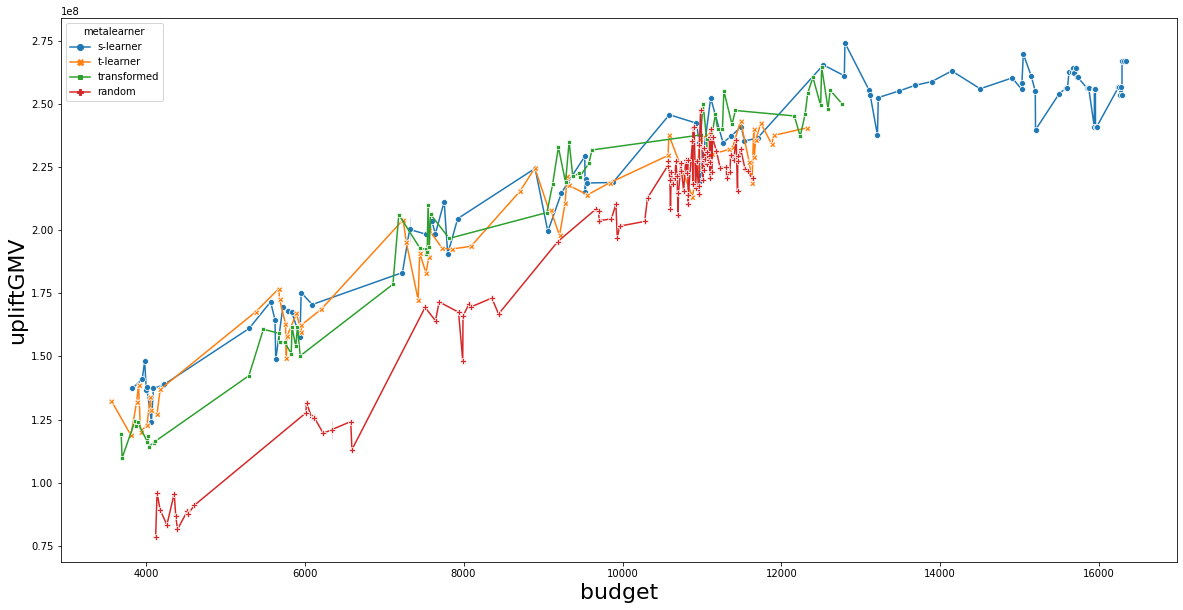

In [58]:
# TODO: 一致するものは＋、一致しないものはーにするようにして評価
results = []
n_sample = min(container.test_df.shape[0], config.postprocess_config.n_sample)
random_checked = set()
# self.assignments.append([name, seed, budget_constraint, assignment])
for name, seed, budget_constraint, assginment in container.assignments:
    if name not in ['s-learner','t-learner', 'transformed']:
        continue
    # test_dfからランダムにn_sample個のidxを取得
    sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
    # sample_idxのデータを取得しsample_dfに格納
    sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
    # target列にGMVを代入
    sample_df['target'] = sample_df[container.config.target_name]
    # sample_dfのなかで各config.treatment_nameの数をカウント
    n_treatment = sample_df[config.treatment_name].value_counts().to_dict()
    n_treatment_all = sum(n_treatment.values())
    # cost列にvariant_no_to_costの値を代入
    sample_df['cost'] = sample_df[config.treatment_name].map(postprocess_config.variant_no_to_cost)
    # random
    if (seed,budget_constraint) not in random_checked:
        # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
        # assign_indexはあとで0にするindex
        assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
        # assginment列に0~6の乱数を代入 -> 1~6では？ 
        sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
        # assgin_indexのidxに0を上書き
        sample_df.loc[assgin_index, 'assginment'] = 0
        # upliftgmv
        random_gmv = 0
        cost = 0
        for t in range(1, 7):
            random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[config.treatment_name]==t)].sum()
            #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        # 一致しているものの割合 -> つかってない
        # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
        random_rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
        results.append(['random', seed, cost, random_gmv, random_rate])   
        random_checked.add((seed,budget_constraint))
        
    # model
    gmv = 0
    cost = 0
    for t in range(1, 7):
        gmv += sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
        gmv -= sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        cost += sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()
        # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
    rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
    results.append([name, seed, cost, gmv, rate])

result_df = pd.DataFrame(results, columns=['metalearner', 'seed', 'cost', 'GMV', 'assign_rate'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['metalearner'] == 'random'
result_df = result_df.sort_values(['random', 'metalearner','cost','seed'])

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=result_df, y='GMV', x='cost', hue='metalearner', 
             style='metalearner',
             markers=True, 
             dashes=False,
             ax=ax)
ax.set_xlabel('budget', fontsize=22)
ax.set_ylabel('upliftGMV',fontsize=22)
fig.savefig(str(config.dir_config.output_figure_dir / 'cvr.png'))

## CPupliftGMVの評価

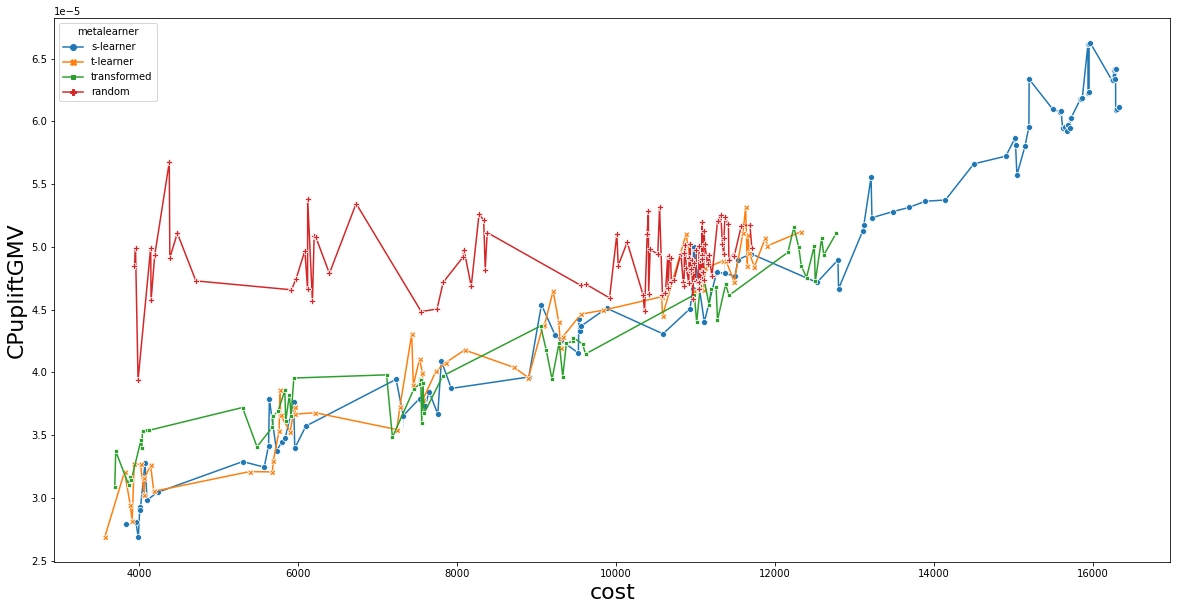

In [57]:
# TODO: 一致するものは＋、一致しないものはーにするようにして評価
results = []
n_sample = min(container.test_df.shape[0], config.postprocess_config.n_sample)
random_checked = set()
# self.assignments.append([name, seed, budget_constraint, assignment])
for name, seed, budget_constraint, assginment in container.assignments:
    if name not in ['s-learner','t-learner', 'transformed']:
        continue
    # test_dfからランダムにn_sample個のidxを取得
    sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
    # sample_idxのデータを取得しsample_dfに格納
    sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
    # target列にGMVを代入
    sample_df['target'] = sample_df[container.config.target_name]
    # sample_dfのなかで各config.treatment_nameの数をカウント
    n_treatment = sample_df[config.treatment_name].value_counts().to_dict()
    n_treatment_all = sum(n_treatment.values())
    # cost列にvariant_no_to_costの値を代入
    sample_df['cost'] = sample_df[config.treatment_name].map(postprocess_config.variant_no_to_cost)
    # random
    if (seed,budget_constraint) not in random_checked:
        # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
        # assign_indexはあとで0にするindex
        assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
        # assginment列に0~6の乱数を代入 -> 1~6では？ 
        sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
        # assgin_indexのidxに0を上書き
        sample_df.loc[assgin_index, 'assginment'] = 0
        # upliftgmv
        random_gmv = 0
        cost = 0
        for t in range(1, 7):
            random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[config.treatment_name]==t)].sum()
            #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        # 一致しているものの割合 -> つかってない
        # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
        random_rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
        results.append(['random', seed, cost, random_gmv, random_rate])   
        random_checked.add((seed,budget_constraint))
        
    # model
    gmv = 0
    cost = 0
    for t in range(1, 7):
        gmv += sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
        gmv -= sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        cost += sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()
        # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
    rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
    results.append([name, seed, cost, gmv, rate])

result_df = pd.DataFrame(results, columns=['metalearner', 'seed', 'cost', 'GMV', 'assign_rate'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['metalearner'] == 'random'
result_df['CPupliftGMV'] = result_df['cost']/result_df['GMV']
result_df = result_df.sort_values(['random', 'metalearner','cost','CPupliftGMV','seed'])

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=result_df, y='CPupliftGMV', x='cost', hue='metalearner', 
             style='metalearner',
             markers=True, 
             dashes=False,
             ax=ax)
ax.set_xlabel('budget', fontsize=22)
ax.set_ylabel('CPupliftGMV',fontsize=22)
fig.savefig(str(config.dir_config.output_figure_dir / 'cvr.png'))

## GreedyとのCPupliftGMVの比較

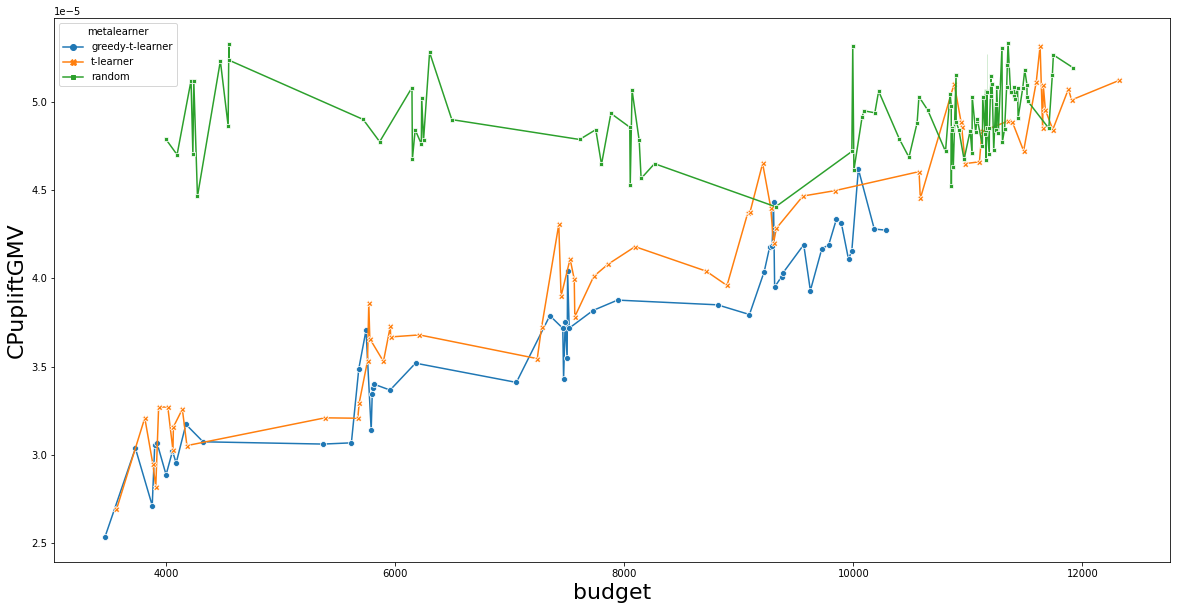

In [61]:
# TODO: 一致するものは＋、一致しないものはーにするようにして評価
results = []
n_sample = min(container.test_df.shape[0], config.postprocess_config.n_sample)
random_checked = set()
# self.assignments.append([name, seed, budget_constraint, assignment])
for name, seed, budget_constraint, assginment in container.assignments:
    if name not in ['t-learner', 'greedy-t-learner']:
        continue
    # test_dfからランダムにn_sample個のidxを取得
    sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
    # sample_idxのデータを取得しsample_dfに格納
    sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
    # target列にGMVを代入
    sample_df['target'] = sample_df[container.config.target_name]
    # sample_dfのなかで各config.treatment_nameの数をカウント
    n_treatment = sample_df[config.treatment_name].value_counts().to_dict()
    n_treatment_all = sum(n_treatment.values())
    # cost列にvariant_no_to_costの値を代入
    sample_df['cost'] = sample_df[config.treatment_name].map(postprocess_config.variant_no_to_cost)
    # random
    if (seed,budget_constraint) not in random_checked:
        # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
        # assign_indexはあとで0にするindex
        assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
        # assginment列に0~6の乱数を代入 -> 1~6では？ 
        sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
        # assgin_indexのidxに0を上書き
        sample_df.loc[assgin_index, 'assginment'] = 0
        # upliftgmv
        random_gmv = 0
        cost = 0
        for t in range(1, 7):
            random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[config.treatment_name]==t)].sum()
            #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        # 一致しているものの割合 -> つかってない
        # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
        random_rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
        results.append(['random', seed, cost, random_gmv, random_rate])   
        random_checked.add((seed,budget_constraint))
        
    # model
    gmv = 0
    cost = 0
    for t in range(1, 7):
        gmv += sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
        gmv -= sample_df['target'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        cost += sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]==t)].sum()
        # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
    rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
    results.append([name, seed, cost, gmv, rate])

result_df = pd.DataFrame(results, columns=['metalearner', 'seed', 'cost', 'GMV', 'assign_rate'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['metalearner'] == 'random'
result_df['CPupliftGMV'] = result_df['cost']/result_df['GMV']
result_df = result_df.sort_values(['random', 'metalearner','cost','CPupliftGMV','seed'])

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=result_df, y='CPupliftGMV', x='cost', hue='metalearner', 
             style='metalearner',
             markers=True, 
             dashes=False,
             ax=ax)
ax.set_xlabel('budget', fontsize=22)
ax.set_ylabel('CPupliftGMV',fontsize=22)
fig.savefig(str(config.dir_config.output_figure_dir / 'cvr.png'))